In [ ]:
import os
import numpy as np
import pandas as pd
#from sklearn.preprocessing import StandardScaler
import json

# after you do a pass through this, you will need to pad the gen_names vectors with seen_set
#print((all_files))      
# need map from file name to cancer type label (y)
clinical_df = pd.read_csv('/content/drive/MyDrive/clinical.tsv', sep='\t')
# should I use this as a source? Yes and no, save it as simpler and keep for retargeting of smaller subtypes within a cancer type
all_map = clinical_df[["case_id", "primary_diagnosis"]]
# take only first 3 words of each entry and remove commas for easier subtype labeling
cases = clinical_df["case_id"]
simplified_names = clinical_df['primary_diagnosis'].str.split().str[:3].str.join(" ").str.replace(',', '')
# now turn these into a map 
simple_df = pd.concat([cases, simplified_names], axis=1)
simple_map = simple_df.set_index('case_id').to_dict()['primary_diagnosis']
#print(simple_map)


# need a map from file names to case id, from case id to primary diagnosis
json_file = open('/content/drive/MyDrive/metadata.json',)
y = json.load(json_file)
#print(y)
f_name_2_case_id = dict()
for file in y:
  #print(file)
  f_name_2_case_id[".".join(file["file_name"].split(".")[:-1])] = file["associated_entities"][0]["case_id"]

# need to give these a number label 
type_map = set()

for file in f_name_2_case_id.keys():
  try:
    type_map.add(simple_map[f_name_2_case_id[file]])
  except:
    pass
  
print(len(type_map))

type_map = list(type_map)
label_ls = []
used_files = []
for file in f_name_2_case_id.keys():
  try:
    label_ls.append(type_map.index(simple_map[f_name_2_case_id[file]]))
    used_files.append(file)
  except:
    pass

print(np.array(used_files))
print((np.array(label_ls)))

33
['9d32f4f3-9130-4246-b782-b0d45003e4bb.FPKM.txt'
 'b1fec85b-c956-4380-bb34-da85df702078.FPKM.txt'
 '04cf69ae-f944-4287-b1da-80fb5524955f.FPKM.txt' ...
 '2dee236e-d1a7-4dcc-9008-8db6955842a2.FPKM.txt'
 '7e599d76-398e-4f50-924c-e24603371108.FPKM.txt'
 '4ade0a98-5d4b-4f67-b5f4-86621b19ec0f.FPKM.txt']
[23 23 23 ... 23 23 23]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
type_map

['Myeloid sarcoma',
 'Acute megakaryoblastic leukaemia',
 'Refractory cytopenia with',
 'Juvenile myelomonocytic leukemia',
 'Myeloid leukemia associated',
 'Chronic myelomonocytic leukemia',
 'Unknown',
 'Acute promyelocytic leukaemia',
 'Precursor B-cell lymphoblastic',
 'Acute erythroid leukaemia',
 'B lymphoblastic leukemia/lymphoma',
 'Leukemia NOS',
 'Not Reported',
 'Burkitt lymphoma NOS',
 'Acute monoblastic and',
 'Tumor NOS',
 'Atypical chronic myeloid',
 'Myelodysplastic syndrome unclassifiable',
 'Essential thrombocythemia',
 'Chronic neutrophilic leukemia',
 'Acute myeloid leukemia',
 'Neuroblastoma NOS',
 'Plasma cell myeloma',
 'Multiple myeloma',
 'Burkitt-like lymphoma',
 'Therapy related myeloid',
 'Myloproliferative neoplasm unclassifiable',
 'Mixed phenotype acute',
 'Myelodysplastic/myeloproliferative neoplasm unclassifiable',
 'Refractory anemia with',
 'T lymphoblastic leukemia/lymphoma',
 'Undifferentiated leukaemia',
 'Acute myelomonocytic leukemia']

In [ ]:

# do two passes? yes. one for seen_set
# second to grab all the expression vects
seen_set = set()
all_files = dict()
data = np.empty([1,60484])

target_dir = "/content/drive/MyDrive/RNAseq_files/"
counter = 0
for root, dirs, files in os.walk(target_dir):
    for file in files: 
        if file.endswith(".txt"):
          if file in f_name_2_case_id.keys() and f_name_2_case_id[file] in simple_map:
            counter += 1
            file_in_dir = target_dir + file
            gene_names = []
            expression_values = []
            with open(file_in_dir) as f:
                line = f.readline().strip().split("\t")
                expression_values.append(float(line[1]))
                while line:
                    line = f.readline().strip().split("\t")
                    if len(line) == 2:
                        expression_values.append(float(line[1]))
                    else:
                        break
                # apply the normalization here across all the expression values
                expression_values = [1.0 if i < 1 else i for i in expression_values]
                expression_values = np.log2(np.array(expression_values))
                # add label 
                expression_values = np.append(np.array(expression_values), float(type_map.index(simple_map[f_name_2_case_id[file]])))
                expression_values = expression_values[:,np.newaxis].T
                # turn all floats less than 1 to 1 and log2 transform
                #expression_values = np.log2(np.array(expression_values))
                data = np.vstack((data,expression_values))
            if (counter) % 100 == 0:
              print(counter)

print(data.shape)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2579, 60484)


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
real_data = data[1:,]
n_classes = len(type_map)
# don't binarize here
#Y = label_binarize(real_data[:,-1], classes=[*range(n_classes)])
#print(real_data[:,:-1].shape, Y.shape)
train_X, test_X, train_Y, test_Y = train_test_split(real_data[:,:-1], real_data[:,-1])
print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(1933, 60483) (645, 60483) (1933,) (645,)


In [ ]:
label_counts = dict()
for label in real_data[:,-1]:
  label_counts[label] = 0

for label in real_data[:,-1]:
  label_counts[label] += 1

label_counts

{0.0: 3,
 1.0: 1,
 2.0: 1,
 3.0: 1,
 4.0: 1,
 5.0: 5,
 6.0: 66,
 7.0: 17,
 8.0: 276,
 9.0: 1,
 10.0: 3,
 11.0: 12,
 12.0: 6,
 13.0: 96,
 14.0: 12,
 15.0: 2,
 16.0: 19,
 17.0: 3,
 18.0: 1,
 19.0: 16,
 20.0: 722,
 21.0: 1,
 22.0: 1,
 23.0: 859,
 24.0: 15,
 25.0: 40,
 26.0: 5,
 27.0: 91,
 28.0: 7,
 29.0: 3,
 30.0: 267,
 31.0: 5,
 32.0: 20}

In [ ]:
re_sum = 0
keep_track = []
for label, count in label_counts.items():
  if count < 10:
    re_sum += count
    keep_track.append(label)
#
print(re_sum, keep_track)

50 [31.0, 29.0, 28.0, 15.0, 5.0, 26.0, 10.0, 17.0, 3.0, 0.0, 22.0, 2.0, 1.0, 12.0, 21.0, 9.0, 18.0, 4.0]


In [ ]:
# should remove all classes with less than 5 examples
val, count = np.unique(real_data[:,-1], return_counts=True)
out = real_data[np.isin(real_data[:, -1], val[np.isin(val, val[count>5])])] 
print(out.shape)

(2541, 60484)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import precision_recall_curve, roc_curve
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score

target_names = type_map

names = ["Most Frequent", 
         "Decision Tree", 
         "Gaussian NB", 
         "Random Forest", 
         "L-2 Penalized Logistic Regression"
         ] 
estimators = [DummyClassifier(strategy='most_frequent'), 
              tree.DecisionTreeClassifier(),
              GaussianNB(), 
              RandomForestClassifier(), 
              LogisticRegression(solver="liblinear")
              ] 
decision_functions = []
predictions = []
scores = []
feature_rankings = []

real_data = out
X, y = real_data[:,:-1], real_data[:,-1]
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

p_scores, r_scores, ba_scores, f_scores, roc_scores = [], [], [], [], []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  precision_scores, recall_scores, f1_scores, balanced_accuracy_scores, roc_auc_scores = [], [], [], [], []
  for estimator in estimators:
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    recall_scores.append(precision_score(y_test, y_pred, average="macro"))
    precision_scores.append(recall_score(y_test, y_pred, average="macro"))
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, estimator.predict_proba(X_test), multi_class='ovr'))

  p_scores.append(precision_scores)
  r_scores.append(recall_scores)
  f_scores.append(f1_scores)
  ba_scores.append(balanced_accuracy_scores)
  roc_scores.append(roc_auc_scores)

p_scores = np.array(p_scores)
r_scores = np.array(r_scores)
f_scores = np.array(f_scores)
ba_scores = np.array(ba_scores)
roc_scores = np.array(roc_scores)

for i in range(len(estimators)):
  print("the macro precision score of", names[i], "is", np.mean(p_scores[:,i]))
  print("the macro recall score of", names[i], "is", np.mean(r_scores[:,i]))
  print("the macro f1 score score of", names[i], "is", np.mean(f_scores[:,i]))
  print("the mean balanced accuracy score of", names[i], "is",np.mean(ba_scores[:,i]))
  print("the mean roc auc score of", names[i], "is",np.mean(roc_scores[:, i]))
  print("")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

the macro precision score of Most Frequent is 0.058823529411764705
the macro recall score of Most Frequent is 0.019885312615612282
the macro f1 score score of Most Frequent is 0.02972281744660261
the mean balanced accuracy score of Most Frequent is 0.058823529411764705
the mean roc auc score of Most Frequent is 0.5

the macro precision score of Decision Tree is 0.43079340038316144
the macro recall score of Decision Tree is 0.4192928585417029
the macro f1 score score of Decision Tree is 0.4211956801431681
the mean balanced accuracy score of Decision Tree is 0.43079340038316144
the mean roc auc score of Decision Tree is 0.7109704165871651

the macro precision score of Gaussian NB is 0.3474404528928675
the macro recall score of Gaussian NB is 0.41539571592066293
the macro f1 score score of Gaussian NB is 0.3525255117776638
the mean balanced accuracy score of Gaussian NB is 0.3474404528928675
the mean roc auc score of Gaussian NB is 0.669483405841839

the macro precision score of Random Fo

In [ ]:
master_p_scores, master_r_scores, master_f_scores, master_ba_scores, master_roc_scores = [], [], [], [], []


master_p_scores.append(p_scores)
master_r_scores.append(r_scores)
master_f_scores.append(f_scores)
master_ba_scores.append(ba_scores)
master_roc_scores.append(roc_scores)


['Myeloid sarcoma', 'Acute megakaryoblastic leukaemia', 'Refractory cytopenia with', 'Juvenile myelomonocytic leukemia', 'Myeloid leukemia associated', 'Chronic myelomonocytic leukemia', 'Unknown', 'Acute promyelocytic leukaemia', 'Precursor B-cell lymphoblastic', 'Acute erythroid leukaemia', 'B lymphoblastic leukemia/lymphoma', 'Leukemia NOS', 'Not Reported', 'Burkitt lymphoma NOS', 'Acute monoblastic and', 'Tumor NOS', 'Atypical chronic myeloid', 'Myelodysplastic syndrome unclassifiable', 'Essential thrombocythemia', 'Chronic neutrophilic leukemia', 'Acute myeloid leukemia', 'Neuroblastoma NOS', 'Plasma cell myeloma', 'Multiple myeloma', 'Burkitt-like lymphoma', 'Therapy related myeloid', 'Myloproliferative neoplasm unclassifiable', 'Mixed phenotype acute', 'Myelodysplastic/myeloproliferative neoplasm unclassifiable', 'Refractory anemia with', 'T lymphoblastic leukemia/lymphoma', 'Undifferentiated leukaemia', 'Acute myelomonocytic leukemia']
['Unknown', 'Acute promyelocytic leukaemia

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2541, 2)


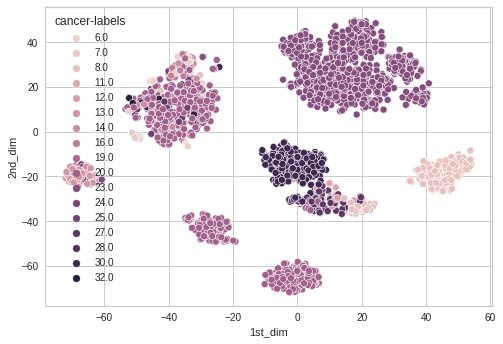

In [ ]:
# look at the original data
from sklearn.manifold import TSNE
import seaborn as sns

labels = type_map.copy()

for i in keep_track:
  labels.remove(type_map[int(i)])

print(type_map)
print(labels)
X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_tsne.shape)
df_plot = pd.DataFrame([X_tsne[:, 0], X_tsne[:, 1], y]).T
df_plot.columns = ['1st_dim', '2nd_dim', 'cancer-labels']
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'cancer-labels',data=df_plot, legend="full")

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedShuffleSplit

target_names = type_map

names = ["Most Frequent", 
         "Decision Tree", 
         "Gaussian NB", 
         "Random Forest", 
         "L-2 Penalized Logistic Regression"
         ] 
estimators = [DummyClassifier(strategy='most_frequent'), 
              tree.DecisionTreeClassifier(),
              GaussianNB(), 
              RandomForestClassifier(), 
              LogisticRegression(solver="liblinear")
              ] 
decision_functions = []
predictions = []
scores = []
feature_rankings = []

real_data = out
X, y = real_data[:,:-1], real_data[:,-1]
sel = VarianceThreshold(threshold=(5))
X = sel.fit_transform(real_data[:,:-1])
print(X.shape)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

p_scores, r_scores, ba_scores, f_scores, roc_scores = [], [], [], [], []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  precision_scores, recall_scores, f1_scores, balanced_accuracy_scores, roc_auc_scores = [], [], [], [], []
  for estimator in estimators:
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    recall_scores.append(precision_score(y_test, y_pred, average="macro"))
    precision_scores.append(recall_score(y_test, y_pred, average="macro"))
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, estimator.predict_proba(X_test), multi_class='ovr'))
  p_scores.append(precision_scores)
  r_scores.append(recall_scores)
  f_scores.append(f1_scores)
  ba_scores.append(balanced_accuracy_scores)
  roc_scores.append(roc_auc_scores)

p_scores = np.array(p_scores)
r_scores = np.array(r_scores)
f_scores = np.array(f_scores)
ba_scores = np.array(ba_scores)
roc_scores = np.array(roc_scores)

for i in range(len(estimators)):
  print("the macro precision score of", names[i], "is", np.mean(p_scores[:,i]))
  print("the macro recall score of", names[i], "is", np.mean(r_scores[:,i]))
  print("the macro f1 score score of", names[i], "is", np.mean(f_scores[:,i]))
  print("the mean balanced accuracy score of", names[i], "is",np.mean(ba_scores[:,i]))
  print("the mean roc auc score of", names[i], "is",np.mean(roc_scores[:, i]))
  print("")


(2541, 1060)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

the macro precision score of Most Frequent is 0.058823529411764705
the macro recall score of Most Frequent is 0.019885312615612282
the macro f1 score score of Most Frequent is 0.02972281744660261
the mean balanced accuracy score of Most Frequent is 0.058823529411764705
the mean roc auc score of Most Frequent is 0.5

the macro precision score of Decision Tree is 0.4382018351701286
the macro recall score of Decision Tree is 0.45456759673138886
the macro f1 score score of Decision Tree is 0.433999507565482
the mean balanced accuracy score of Decision Tree is 0.4382018351701286
the mean roc auc score of Decision Tree is 0.7145698063794963

the macro precision score of Gaussian NB is 0.3929135975734764
the macro recall score of Gaussian NB is 0.40524955188992956
the macro f1 score score of Gaussian NB is 0.3689021388714907
the mean balanced accuracy score of Gaussian NB is 0.3929135975734764
the mean roc auc score of Gaussian NB is 0.7116896435942275

the macro precision score of Random For

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['Myeloid sarcoma', 'Acute megakaryoblastic leukaemia', 'Refractory cytopenia with', 'Juvenile myelomonocytic leukemia', 'Myeloid leukemia associated', 'Chronic myelomonocytic leukemia', 'Unknown', 'Acute promyelocytic leukaemia', 'Precursor B-cell lymphoblastic', 'Acute erythroid leukaemia', 'B lymphoblastic leukemia/lymphoma', 'Leukemia NOS', 'Not Reported', 'Burkitt lymphoma NOS', 'Acute monoblastic and', 'Tumor NOS', 'Atypical chronic myeloid', 'Myelodysplastic syndrome unclassifiable', 'Essential thrombocythemia', 'Chronic neutrophilic leukemia', 'Acute myeloid leukemia', 'Neuroblastoma NOS', 'Plasma cell myeloma', 'Multiple myeloma', 'Burkitt-like lymphoma', 'Therapy related myeloid', 'Myloproliferative neoplasm unclassifiable', 'Mixed phenotype acute', 'Myelodysplastic/myeloproliferative neoplasm unclassifiable', 'Refractory anemia with', 'T lymphoblastic leukemia/lymphoma', 'Undifferentiated leukaemia', 'Acute myelomonocytic leukemia']
['Unknown', 'Acute promyelocytic leukaemia

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2541, 2)


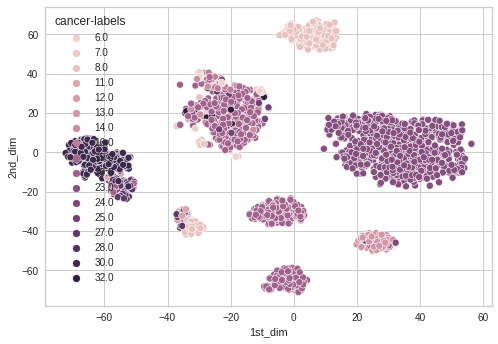

In [ ]:
# look at the original data
from sklearn.manifold import TSNE
import seaborn as sns

labels = type_map.copy()

for i in keep_track:
  labels.remove(type_map[int(i)])

print(type_map)
print(labels)
X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_tsne.shape)
df_plot = pd.DataFrame([X_tsne[:, 0], X_tsne[:, 1], y]).T
df_plot.columns = ['1st_dim', '2nd_dim', 'cancer-labels']
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'cancer-labels',data=df_plot, legend="full")

In [ ]:
master_p_scores.append(p_scores)
master_r_scores.append(r_scores)
master_f_scores.append(f_scores)
master_ba_scores.append(ba_scores)
master_roc_scores.append(roc_scores)


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

target_names = type_map

names = ["Most Frequent", 
         "Decision Tree", 
         "Gaussian NB", 
         "Random Forest", 
         "L-2 Penalized Logistic Regression"
         ] 
estimators = [DummyClassifier(strategy='most_frequent'), 
              tree.DecisionTreeClassifier(),
              GaussianNB(), 
              RandomForestClassifier(), 
              LogisticRegression(solver="liblinear")
              ] 
decision_functions = []
predictions = []
scores = []
feature_rankings = []

real_data = out
X, y = real_data[:,:-1], real_data[:,-1]


X = SelectKBest(mutual_info_classif, k=1000).fit_transform(X, y)
print(X.shape)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

p_scores, r_scores, ba_scores, f_scores, roc_scores = [], [], [], [], []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  precision_scores, recall_scores, f1_scores, balanced_accuracy_scores, roc_auc_scores = [], [], [], [], []
  for estimator in estimators:
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    recall_scores.append(precision_score(y_test, y_pred, average="macro"))
    precision_scores.append(recall_score(y_test, y_pred, average="macro"))
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, estimator.predict_proba(X_test), multi_class='ovr'))
  p_scores.append(precision_scores)
  r_scores.append(recall_scores)
  f_scores.append(f1_scores)
  ba_scores.append(balanced_accuracy_scores)
  roc_scores.append(roc_auc_scores)

p_scores = np.array(p_scores)
r_scores = np.array(r_scores)
f_scores = np.array(f_scores)
ba_scores = np.array(ba_scores)
roc_scores = np.array(roc_scores)

for i in range(len(estimators)):
  print("the macro precision score of", names[i], "is", np.mean(p_scores[:,i]))
  print("the macro recall score of", names[i], "is", np.mean(r_scores[:,i]))
  print("the macro f1 score score of", names[i], "is", np.mean(f_scores[:,i]))
  print("the mean balanced accuracy score of", names[i], "is",np.mean(ba_scores[:,i]))
  print("the mean roc auc score of", names[i], "is",np.mean(roc_scores[:, i]))
  print("")


(2541, 1000)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

the macro precision score of Most Frequent is 0.058823529411764705
the macro recall score of Most Frequent is 0.019885312615612282
the macro f1 score score of Most Frequent is 0.02972281744660261
the mean balanced accuracy score of Most Frequent is 0.058823529411764705
the mean roc auc score of Most Frequent is 0.5

the macro precision score of Decision Tree is 0.4386852085673848
the macro recall score of Decision Tree is 0.4168506212161879
the macro f1 score score of Decision Tree is 0.41975742198335303
the mean balanced accuracy score of Decision Tree is 0.4386852085673848
the mean roc auc score of Decision Tree is 0.7146185007803798

the macro precision score of Gaussian NB is 0.472565944071169
the macro recall score of Gaussian NB is 0.4762587067984877
the macro f1 score score of Gaussian NB is 0.4456850968350093
the mean balanced accuracy score of Gaussian NB is 0.472565944071169
the mean roc auc score of Gaussian NB is 0.7945691561549262

the macro precision score of Random Fores

['Myeloid sarcoma', 'Acute megakaryoblastic leukaemia', 'Refractory cytopenia with', 'Juvenile myelomonocytic leukemia', 'Myeloid leukemia associated', 'Chronic myelomonocytic leukemia', 'Unknown', 'Acute promyelocytic leukaemia', 'Precursor B-cell lymphoblastic', 'Acute erythroid leukaemia', 'B lymphoblastic leukemia/lymphoma', 'Leukemia NOS', 'Not Reported', 'Burkitt lymphoma NOS', 'Acute monoblastic and', 'Tumor NOS', 'Atypical chronic myeloid', 'Myelodysplastic syndrome unclassifiable', 'Essential thrombocythemia', 'Chronic neutrophilic leukemia', 'Acute myeloid leukemia', 'Neuroblastoma NOS', 'Plasma cell myeloma', 'Multiple myeloma', 'Burkitt-like lymphoma', 'Therapy related myeloid', 'Myloproliferative neoplasm unclassifiable', 'Mixed phenotype acute', 'Myelodysplastic/myeloproliferative neoplasm unclassifiable', 'Refractory anemia with', 'T lymphoblastic leukemia/lymphoma', 'Undifferentiated leukaemia', 'Acute myelomonocytic leukemia']
['Unknown', 'Acute promyelocytic leukaemia

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2541, 2)


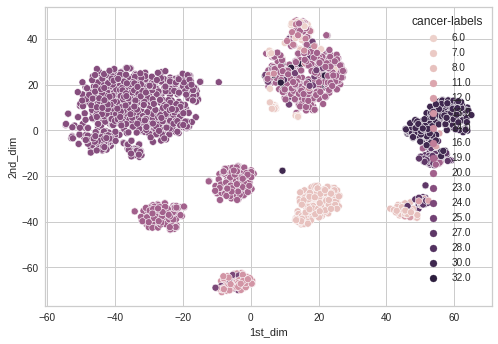

In [ ]:
# look at the original data
from sklearn.manifold import TSNE
import seaborn as sns

labels = type_map.copy()

for i in keep_track:
  labels.remove(type_map[int(i)])

print(type_map)
print(labels)
X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_tsne.shape)
df_plot = pd.DataFrame([X_tsne[:, 0], X_tsne[:, 1], y]).T
df_plot.columns = ['1st_dim', '2nd_dim', 'cancer-labels']
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'cancer-labels',data=df_plot, legend="full")

In [ ]:
master_p_scores.append(p_scores)
master_r_scores.append(r_scores)
master_f_scores.append(f_scores)
master_ba_scores.append(ba_scores)
master_roc_scores.append(roc_scores)


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

target_names = type_map

names = ["Most Frequent", 
         "Decision Tree", 
         "Gaussian NB", 
         "Random Forest", 
         "L-2 Penalized Logistic Regression"
         ] 
estimators = [DummyClassifier(strategy='most_frequent'), 
              tree.DecisionTreeClassifier(),
              GaussianNB(), 
              RandomForestClassifier(), 
              LogisticRegression(solver="liblinear")
              ] 
decision_functions = []
predictions = []
scores = []
feature_rankings = []

real_data = out
X, y = real_data[:,:-1], real_data[:,-1]


X = SelectKBest(mutual_info_classif, k=5).fit_transform(X, y)
print(X.shape)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

p_scores, r_scores, ba_scores, f_scores, roc_scores = [], [], [], [], []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  precision_scores, recall_scores, f1_scores, balanced_accuracy_scores, roc_auc_scores = [], [], [], [], []
  for estimator in estimators:
    estimator = estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    recall_scores.append(precision_score(y_test, y_pred, average="macro"))
    precision_scores.append(recall_score(y_test, y_pred, average="macro"))
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, estimator.predict_proba(X_test), multi_class='ovr'))
  p_scores.append(precision_scores)
  r_scores.append(recall_scores)
  f_scores.append(f1_scores)
  ba_scores.append(balanced_accuracy_scores)
  roc_scores.append(roc_auc_scores)

p_scores = np.array(p_scores)
r_scores = np.array(r_scores)
f_scores = np.array(f_scores)
ba_scores = np.array(ba_scores)
roc_scores = np.array(roc_scores)

for i in range(len(estimators)):
  print("the macro precision score of", names[i], "is", np.mean(p_scores[:,i]))
  print("the macro recall score of", names[i], "is", np.mean(r_scores[:,i]))
  print("the macro f1 score score of", names[i], "is", np.mean(f_scores[:,i]))
  print("the mean balanced accuracy score of", names[i], "is",np.mean(ba_scores[:,i]))
  print("the mean roc auc score of", names[i], "is",np.mean(roc_scores[:, i]))
  print("")


(2541, 5)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

the macro precision score of Most Frequent is 0.058823529411764705
the macro recall score of Most Frequent is 0.019885312615612282
the macro f1 score score of Most Frequent is 0.02972281744660261
the mean balanced accuracy score of Most Frequent is 0.058823529411764705
the mean roc auc score of Most Frequent is 0.5

the macro precision score of Decision Tree is 0.3572980669974898
the macro recall score of Decision Tree is 0.35181132980403507
the macro f1 score score of Decision Tree is 0.34944124640922797
the mean balanced accuracy score of Decision Tree is 0.3572980669974898
the mean roc auc score of Decision Tree is 0.6705522674980511

the macro precision score of Gaussian NB is 0.39308708120258345
the macro recall score of Gaussian NB is 0.3419775699330381
the macro f1 score score of Gaussian NB is 0.3434326486477928
the mean balanced accuracy score of Gaussian NB is 0.39308708120258345
the mean roc auc score of Gaussian NB is 0.9415554850411467

the macro precision score of Random 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['Myeloid sarcoma', 'Acute megakaryoblastic leukaemia', 'Refractory cytopenia with', 'Juvenile myelomonocytic leukemia', 'Myeloid leukemia associated', 'Chronic myelomonocytic leukemia', 'Unknown', 'Acute promyelocytic leukaemia', 'Precursor B-cell lymphoblastic', 'Acute erythroid leukaemia', 'B lymphoblastic leukemia/lymphoma', 'Leukemia NOS', 'Not Reported', 'Burkitt lymphoma NOS', 'Acute monoblastic and', 'Tumor NOS', 'Atypical chronic myeloid', 'Myelodysplastic syndrome unclassifiable', 'Essential thrombocythemia', 'Chronic neutrophilic leukemia', 'Acute myeloid leukemia', 'Neuroblastoma NOS', 'Plasma cell myeloma', 'Multiple myeloma', 'Burkitt-like lymphoma', 'Therapy related myeloid', 'Myloproliferative neoplasm unclassifiable', 'Mixed phenotype acute', 'Myelodysplastic/myeloproliferative neoplasm unclassifiable', 'Refractory anemia with', 'T lymphoblastic leukemia/lymphoma', 'Undifferentiated leukaemia', 'Acute myelomonocytic leukemia']
['Unknown', 'Acute promyelocytic leukaemia

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2541, 2)


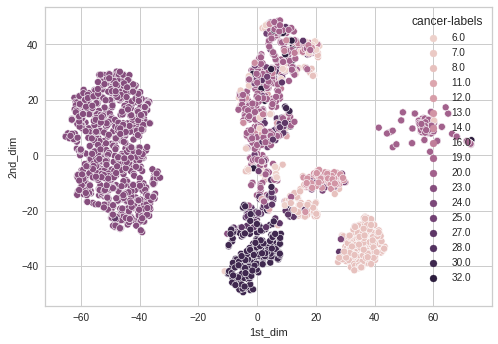

In [ ]:
# look at the original data
from sklearn.manifold import TSNE
import seaborn as sns

labels = type_map.copy()

for i in keep_track:
  labels.remove(type_map[int(i)])

print(type_map)
print(labels)
X_tsne = TSNE(n_components=2).fit_transform(X)
print(X_tsne.shape)
df_plot = pd.DataFrame([X_tsne[:, 0], X_tsne[:, 1], y]).T
df_plot.columns = ['1st_dim', '2nd_dim', 'cancer-labels']
sns.scatterplot(x='1st_dim', y='2nd_dim', hue = 'cancer-labels',data=df_plot, legend="full")

In [ ]:
master_p_scores.append(p_scores)
master_r_scores.append(r_scores)
master_f_scores.append(f_scores)
master_ba_scores.append(ba_scores)
master_roc_scores.append(roc_scores)

In [ ]:
# need RFE for a wrapper method

# need a new train_test instance
target_names = type_map

names = ["Most Frequent", 
         "Decision Tree", 
         "Gaussian NB", 
         "Random Forest", 
         "L-2 Penalized Logistic Regression"
         ] 
estimators = [DummyClassifier(strategy='most_frequent'), 
              tree.DecisionTreeClassifier(),
              GaussianNB(), 
              RandomForestClassifier(), 
              LogisticRegression(solver="liblinear")
              ] 
decision_functions = []
predictions = []
scores = []
feature_rankings = []

real_data = out
X, y = real_data[:,:-1], real_data[:,-1]



sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
u_features = []
p_scores, r_scores, ba_scores, f_scores, roc_scores = [], [], [], [], []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  precision_scores, recall_scores, f1_scores, balanced_accuracy_scores, roc_auc_scores = [], [], [], [], []
  used_features = []
  for estimator in estimators:
    estimator = estimator.fit(X_train, y_train)
    if estimator != DummyClassifier(strategy='most_frequent'):
      selector = RFE(estimator, n_features_to_select=5, step=1)
      used_features.append(selector.get_support)

    # the estimator should be fit now too 
    y_pred = estimator.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    recall_scores.append(precision_score(y_test, y_pred, average="macro"))
    precision_scores.append(recall_score(y_test, y_pred, average="macro"))
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, estimator.predict_proba(X_test), multi_class='ovr'))
  p_scores.append(precision_scores)
  r_scores.append(recall_scores)
  f_scores.append(f1_scores)
  ba_scores.append(balanced_accuracy_scores)
  roc_scores.append(roc_auc_scores)
  u_features.append(used_features)

p_scores = np.array(p_scores)
r_scores = np.array(r_scores)
f_scores = np.array(f_scores)
ba_scores = np.array(ba_scores)
roc_scores = np.array(roc_scores)

for i in range(len(estimators)):
  print("the macro precision score of", names[i], "is", np.mean(p_scores[:,i]))
  print("the macro recall score of", names[i], "is", np.mean(r_scores[:,i]))
  print("the macro f1 score score of", names[i], "is", np.mean(f_scores[:,i]))
  print("the mean balanced accuracy score of", names[i], "is",np.mean(ba_scores[:,i]))
  print("the mean roc auc score of", names[i], "is",np.mean(roc_scores[:, i]))
  print("")


  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

the macro precision score of Most Frequent is 0.058823529411764705
the macro recall score of Most Frequent is 0.019885312615612282
the macro f1 score score of Most Frequent is 0.02972281744660261
the mean balanced accuracy score of Most Frequent is 0.058823529411764705
the mean roc auc score of Most Frequent is 0.5

the macro precision score of Decision Tree is 0.45672299038879965
the macro recall score of Decision Tree is 0.44377763572654755
the macro f1 score score of Decision Tree is 0.4428265790922626
the mean balanced accuracy score of Decision Tree is 0.45672299038879965
the mean roc auc score of Decision Tree is 0.7237776071284253

the macro precision score of Gaussian NB is 0.36003429673072795
the macro recall score of Gaussian NB is 0.4531911526683368
the macro f1 score score of Gaussian NB is 0.3660947895169754
the mean balanced accuracy score of Gaussian NB is 0.36003429673072795
the mean roc auc score of Gaussian NB is 0.6757490512110537

the macro precision score of Random

In [ ]:
print(u_features[0][0])

In [ ]:
master_p_scores.append(p_scores)
master_r_scores.append(r_scores)
master_f_scores.append(f_scores)
master_ba_scores.append(ba_scores)
master_roc_scores.append(roc_scores)

In [ ]:
master_p_scores = [
                   [0.058823529411764705,  0.43079340038316144, 0.3474404528928675, 0.4447278372307403, 0.5403866141449427],
                   [0.058823529411764705,  0.4382018351701286,  0.3929135975734764, 0.4478854607155262,0.5520532460136474],
                   [0.058823529411764705, 0.4382018351701286, 0.472565944071169, 0.4434221598764595, 0.5538880752375522],
                   [0.058823529411764705, 0.3572980669974898, 0.39308708120258345,0.37597820474487487, 0.24984211326785508],
                   [0.058823529411764705, 0.45672299038879965, 0.36003429673072795, 0.42714860613775596, 0.5772589323732189]
                   ]

In [ ]:
master_p_scores = np.array(master_p_scores)
master_p_scores[4, 4, 0]

IndexError: ignored

In [ ]:
# feature selection
# classifier 
# 5 diff cvs

# this is one for each classifier!
(np.array(master_r_scores)[4, 4, :])

# this is between cross validation runs?
(np.array(master_r_scores)[4, :, 4])

# this is between feature selectors?
(np.array(master_r_scores)[:, 4, 4])

np.array(master_r_scores).shape

(5, 5, 5)

In [ ]:
# make some sort of graph from the score outputs
# 3d arrays to 2d arrays
out_lists = []
master_scores = [np.array(master_r_scores), np.array(master_f_scores), 
                 np.array(master_ba_scores), np.array(master_roc_scores)]
for master_score in master_scores:
  out_list = []
  for fs in range(5):
    ol = []
    for clf in range(5):
      mean = np.mean(master_score[fs,:, clf])
      print(mean)
      ol.append(mean)
    out_list.append(ol)
    print("")
  out_lists.append(out_list)

# dump all the 2d arrays
np.savetxt("master_p_scores.csv", master_p_scores, delimiter=",")
np.savetxt("master_r_scores.csv", out_lists[0], delimiter=",")
np.savetxt("master_f_scores.csv", out_lists[1], delimiter=",")
np.savetxt("master_ba_scores.csv", out_lists[2], delimiter=",")
np.savetxt("master_roc_scores.csv", out_lists[3], delimiter=",")

0.019885312615612282
0.4192928585417029
0.41539571592066293
0.47135337706555136
0.6157233190480189

0.019885312615612282
0.45456759673138886
0.40524955188992956
0.4657736179396079
0.5986631085736275

0.019885312615612282
0.4168506212161879
0.4762587067984877
0.43550225050578606
0.5798023364532238

0.019885312615612282
0.35181132980403507
0.3419775699330381
0.4013304627765777
0.309326229415693

0.019885312615612282
0.44377763572654755
0.4531911526683368
0.4231870275169053
0.6371401166727779

0.02972281744660261
0.4211956801431681
0.3525255117776638
0.4436589156386147
0.5532738624168315

0.02972281744660261
0.433999507565482
0.3689021388714907
0.44541810449251706
0.5553995985962036

0.02972281744660261
0.41975742198335303
0.4456850968350093
0.4343429795555145
0.558370094138875

0.02972281744660261
0.34944124640922797
0.3434326486477928
0.37623921775968655
0.2485588766741995

0.02972281744660261
0.4428265790922626
0.3660947895169754
0.4196450370720573
0.5875135475767473

0.058823529411764

Text(0.5, 1.0, 'Macro Precision')

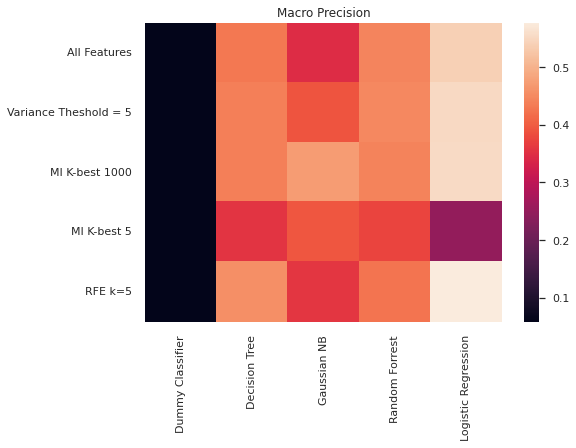

In [ ]:
import seaborn as sns; sns.set_theme()
p_scores = np.loadtxt(open("master_p_scores.csv", "rb"), delimiter=",", skiprows=0)
r_scores = np.loadtxt(open("master_r_scores.csv", "rb"), delimiter=",", skiprows=0)
f_scores = np.loadtxt(open("master_f_scores.csv", "rb"), delimiter=",", skiprows=0)
ba_scores = np.loadtxt(open("master_ba_scores.csv", "rb"), delimiter=",", skiprows=0)
roc_scores = np.loadtxt(open("master_roc_scores.csv", "rb"), delimiter=",", skiprows=0)

col_names = ["All Features", "Variance Theshold = 5", "MI K-best 1000", "MI K-best 5", "RFE k=5"]
row_names = ["Dummy Classifier", "Decision Tree", "Gaussian NB", "Random Forrest", "Logistic Regression"]


import pandas as pd
herbert  = pd.DataFrame(p_scores, columns=row_names)
#p_scores = p_scores.pivot("estimator", "feature size", "score")
#ax = sns.heatmap(p_scores)

ax = sns.heatmap(herbert, yticklabels=col_names)
ax.set_title('Macro Precision')


Text(0.5, 1.0, 'Macro Recall')

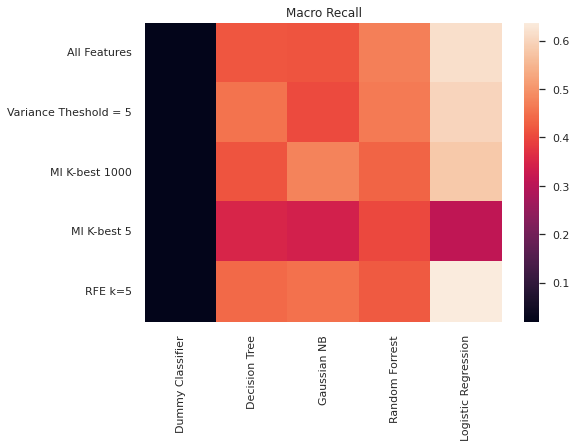

In [ ]:
import pandas as pd
herbert  = pd.DataFrame(r_scores, columns=row_names)
#p_scores = p_scores.pivot("estimator", "feature size", "score")
#ax = sns.heatmap(p_scores)

ax = sns.heatmap(herbert, yticklabels=col_names)
ax.set_title('Macro Recall')

Text(0.5, 1.0, 'Macro F1 Score')

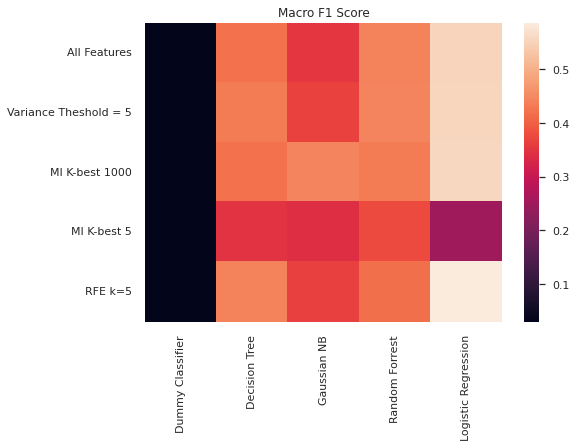

In [ ]:


import pandas as pd
herbert  = pd.DataFrame(f_scores, columns=row_names)
#p_scores = p_scores.pivot("estimator", "feature size", "score")
#ax = sns.heatmap(p_scores)

ax = sns.heatmap(herbert, yticklabels=col_names)
ax.set_title('Macro F1 Score')

Text(0.5, 1.0, 'Mean Balanced Accuracy')

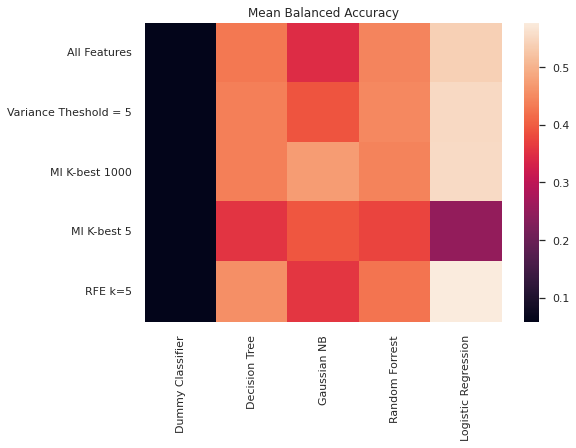

In [ ]:

import pandas as pd
herbert  = pd.DataFrame(ba_scores, columns=row_names)
#p_scores = p_scores.pivot("estimator", "feature size", "score")
#ax = sns.heatmap(p_scores)

ax = sns.heatmap(herbert, yticklabels=col_names)
ax.set_title('Mean Balanced Accuracy')

Text(0.5, 1.0, 'ROC AUC Score')

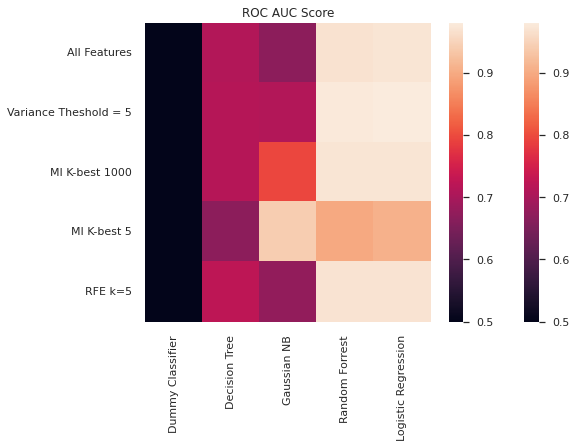

In [ ]:
ax = sns.heatmap(roc_scores)
import pandas as pd
herbert  = pd.DataFrame(roc_scores, columns=row_names)
#p_scores = p_scores.pivot("estimator", "feature size", "score")
#ax = sns.heatmap(p_scores)

ax = sns.heatmap(herbert, yticklabels=col_names)
ax.set_title('ROC AUC Score')